In [1]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
python3-dev is already the newest version (3.6.7-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu116.html
     |████████████████████████████████| 3.5 MB 545 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 32.6 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=df79f7e07b1ebde8acd95a71847f7fee413d1675902aac6d8d07e2a502610b86
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [136]:
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *

from torch_geometric.datasets import TUDataset
import igraph as ig
from igraph import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [137]:
# load six datasets used in the paper
dataset_Enzymes = TUDataset(root='/tmp', name='ENZYMES')
dataset_Proteins = TUDataset(root='/tmp', name='PROTEINS')

dataset_DD = TUDataset(root='/tmp', name='DD') # note to check whether it equals to D&D in paper

dataset_NCI1 = TUDataset(root='/tmp', name='NCI1')
dataset_NCI109 = TUDataset(root='/tmp', name='NCI109')
dataset_Mutagenicity = TUDataset(root='/tmp', name='Mutagenicity')

SELECT WHICH OF THE ABOVE DATASETS YOU WANT TO LOOK AT

In [138]:
dataset = dataset_Enzymes

In [139]:
def info_dataset():
  num_graphs = len(dataset)
  num_classes = dataset.num_classes
  num_node_features = dataset.num_node_features
  print()
  print("Number of graphs: ", num_graphs)
  print("Number of classes: ", num_classes)
  print("Number of node features: ", num_node_features)

In [149]:
def info_degree():
  degree_total = np.sum(g.degree())
  
  print("Average degree:", round((degree_total/g.vcount()),2))
  print("Maximum degree:", max(degrees))

Let's observe a single graph from the data

IN THE FIRST LINE YOU CAN SELECT A SPECIFIC GRAPH (e.g. 10th) OR LEAVE THE DEFAULT VALUE

Data(edge_index=[2, 194], x=[48, 3], y=[1])

Number of graphs:  600
Number of classes:  6
Number of node features:  3

Graph is directed:  False
Number of cliques:  4
Average degree: 8.08
Maximum degree: 10

Number of nodes:  48
Number of edges:  194


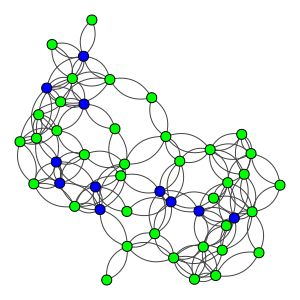

In [150]:
graph_to_work_with = 400


data = dataset[graph_to_work_with]
print(data)

info_dataset()

print()
print("Graph is directed: ", data.is_directed())
print("Number of cliques: ", g.clique_number())

info_degree()

print()
print("Number of nodes: ", g.vcount())
print("Number of edges: ", g.ecount())


# create graph for igraph
edges_df = pd.DataFrame(data.edge_index.T.numpy())
g = Graph.DataFrame(edges_df, directed=data.is_directed())

# plot graph
visual_style = {}
layout = g.layout(layout='drl')
# make the nodes with max. degrees blue (aka hubs)
g.vs["color"] = ["blue" if node.degree()==10 else "green" for node in g.vs]
#visual_style["edge_curved"] = False
ig.plot(g, bbox=(300, 300), margin=20, vertex_size=10, **visual_style)

Show degree distribution

15
15


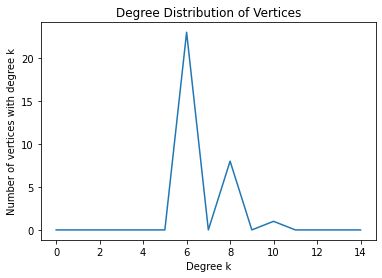

<Figure size 432x288 with 0 Axes>

In [151]:
x = [x for x in range(g.maxdegree()+1)]
degree_counts = [0 for x in range(g.maxdegree()+1)]

for i in degrees:
    degree_counts[i] += 1

print(len(x))
print(len(degree_counts))

plt.figure()
plt.plot(x, degree_counts)
plt.ylabel('Number of vertices with degree k')
plt.xlabel('Degree k')
plt.title('Degree Distribution of Vertices')

plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.show()
plt.draw()

Methods needed for degree correlation

In [143]:
def knn(vertex):
  # print the average degree of neighbors of the vertex
  neighb = g.neighbors(vertex)
  degrees = [g.degree(n) for n in neighb]
  return np.average(degrees)

def print_deg_correlation(g):
  deg_corr = round(g.assortativity_degree(directed=data.is_directed()),2)
  
  if deg_corr > 0:
    print(f"Assortative graph with Degree Correlation Coefficient = {deg_corr}")

  if deg_corr == 0:
    print(f"Neutral graph with Degree Correlation Coefficient = {deg_corr}")

  if deg_corr < 0:
    print(f"Disasortative graph with Degree Correlation Coefficient = {deg_corr}")

def info_degree_correlation(g):
  deg = [x.degree() for x in g.vs]
  avg_deg = [knn(x) for x in g.vs]

  y_mean = [np.mean(avg_deg)]*len(deg)

  plt.figure()
  plt.scatter(deg, avg_deg, label='Data', marker='o')
  plt.plot(deg, y_mean, label='Mean', linestyle='--')
  plt.title("Degree Correlation")
  plt.xlabel("Degree")
  plt.ylabel("Average neighbors degree (knn)")
  plt.legend()
  plt.show()

  print_deg_correlation(g)

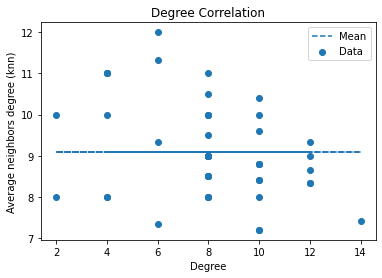

Disasortative graph with Degree Correlation Coefficient = -0.18


In [144]:
info_degree_correlation(g)